In [1]:
import sys

PROJECT_ROOT = '/nfs/turbo/coe-chaijy/janeding/regrounding/clip_tl'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
print('PYTHONPATH added:', sys.path[0])


PYTHONPATH added: /nfs/turbo/coe-chaijy/janeding/regrounding/clip_tl


# Load the model

In [2]:
import torch
from vit_prisma.utils.constants import DEVICE
from vit_prisma.utils.tutorial_utils import (
    plot_image,
)


/home/janeding/miniconda3/envs/prisma/lib/python3.13/site-packages/kaleido/__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [3]:
import gc

# clear cache
torch.cuda.empty_cache()
# force garbage collection
gc.collect()

torch.cuda.set_device(0)
DEVICE = torch.device('cuda:0')


In [4]:
DEVICE = 'cuda'

In [5]:
# transcoder list
from src.analysis.utils import *

tc_list = load_all_tc()

Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-768-x64-all_patches_0-mlp-96/snapshots/b9ff9647261516e5c7a882f7fd130db702c8ea25/weights.pt...
Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-256-x64-all_patches_1-mlp-94/snapshots/96c293a7299a99fe3d70f1f15498215849f22d96/weights.pt...
Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_2-mlp-93/snapshots/cfb7ad837b972edfa27c9719de0e9571893dc434/weights.pt...
Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-Multimodal--CLIP-transcoder-topk-1024-x64-all_patches_3-mlp-90/snapshots/3a169de44e8fa1641a9768aa84f3f99a9edd9828/weights.pt...
Loading SAE from /nfs/turbo/coe-chaijy-unreplicated/pre-trained-weights/prisma-sae/models--Prisma-

In [6]:
# HookedViT
from vit_prisma.models.model_loader import load_hooked_model
from vit_prisma.utils.enums import ModelType

model_name = tc_list[0].cfg.model_name
hookedvit = load_hooked_model(model_name, model_type=ModelType.VISION)
hookedvit = hookedvit.to(DEVICE)

In [7]:
# check: predict label to be 'chemistry'
# load the labels of a big word list for the check, but not the later ablation
import pandas as pd

file_path = '/nfs/turbo/coe-chaijy/janeding/regrounding/MyTC_bert/data/concrete_visual_vocabulary.csv'
labels = pd.read_csv(file_path)

labels = labels.dropna(subset=['word'])
labels['word'] = labels['word'].astype(str).str.lower().str.strip()
labels = labels[labels['word'].ne('')]
labels = labels[labels['word'].ne('nan')]

# turn into dict
label_dict = {
    row['word']: {
        'concreteness': row['concreteness'],
        'imageability': row['imageability'],
    }
    for _, row in labels.iterrows()
}

In [8]:
# load the CLIP text transformer encoder model

import open_clip
import torch
from open_clip.model import text_global_pool
from torch import nn


def name_from_hf(model_name):
    """return model name from huggingface"""
    return model_name.replace('open-clip:', 'hf-hub:')


class OpenCLIPTextOnly(nn.Module):
    def __init__(self, clip):
        super().__init__()
        # only keep the text part of the model
        self.vocab_size = clip.vocab_size
        self.token_embedding = clip.token_embedding
        self.positional_embedding = clip.positional_embedding
        self.transformer = clip.transformer
        self.ln_final = clip.ln_final
        self.text_projection = clip.text_projection
        self.attn_mask = clip.attn_mask
        self.text_pool_type = clip.text_pool_type
        self.text_eos_id = getattr(clip, 'text_eos_id', None)
        # self.register_buffer('attn_mask', self.attn_mask, persistent=False)

    @torch.no_grad()
    def encode_text(self, text, normalize=False):
        cast_dtype = self.transformer.get_cast_dtype()
        x = self.token_embedding(text).to(cast_dtype)  # [B, L, D]
        x = x + self.positional_embedding.to(cast_dtype)
        x = self.transformer(
            x, attn_mask=self.attn_mask
        )  # transformer(width=D)
        x = self.ln_final(x)
        x = text_global_pool(x, text, self.text_pool_type)
        if self.text_projection is not None:
            x = (
                self.text_projection(x)
                if isinstance(self.text_projection, nn.Linear)
                else x @ self.text_projection
            )
        return nn.functional.normalize(x, dim=-1) if normalize else x

    def forward(self, text):
        return self.encode_text(text, normalize=True)


tmp_model, _, _ = open_clip.create_model_and_transforms(
    name_from_hf(tc_list[0].cfg.model_name),
)
tmp_model.to(DEVICE)
tmp_model.eval()

tokenizer = open_clip.get_tokenizer(name_from_hf(tc_list[0].cfg.model_name))

# free up visual tower memory (optional)
if hasattr(tmp_model, 'visual'):
    delattr(tmp_model, 'visual')
    torch.cuda.empty_cache()

text_model = OpenCLIPTextOnly(tmp_model).eval().to(DEVICE)
# text_model.forward(input_ids) or text_model.encode_text(input_ids, normalize=True)

WARNING	Task(Task-2) matplotlib.image:image.py:_normalize_image_array()- Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


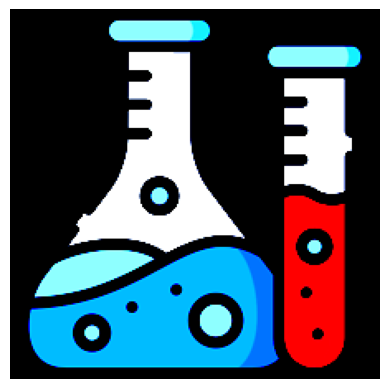

In [9]:
# image

from PIL import Image
from vit_prisma.transforms import get_clip_val_transforms

# img_path = '/nfs/turbo/coe-chaijy/janeding/example_images/smiling-face.png'
img_path = '/nfs/turbo/coe-chaijy/janeding/regrounding/clip_tl/example_images/flask.png'
gt_label = 'chemistry'
img = Image.open(img_path).convert()  # Ensure it's 3 channels
transforms = get_clip_val_transforms()
img_tensor = transforms(img)
plot_image(img_tensor.detach().cpu(), unstandardise=False)

In [10]:
# now try a smaller label set
from custom_labels import final_labels

# final_labels.append('cat')
smaller_text_tokens = open_clip.tokenize(final_labels)

final_labels

['much',
 'weed',
 'test tube',
 'reconnaissance',
 'backlight',
 'laboratory bottle',
 'refrigerator',
 'experiment',
 'funk',
 'enema',
 'disqualify',
 'lab bench',
 'testing',
 'governing',
 'maidenly',
 'hockey stick',
 'tearfulness',
 'discovery',
 'cavity',
 'orbiter',
 'acid',
 'unspoiled',
 'unventilated',
 'disorganize',
 'graduated tube',
 'inclusiveness',
 'misappropriation',
 'spreader',
 'satisfied',
 'ascend',
 'indulgency',
 'pipette',
 'analysis',
 'chairwoman',
 'provided',
 'sewing kit',
 'transducer',
 'nightcaps',
 'lapse',
 'moneyman',
 'science',
 'homogenous',
 'solvent',
 'opalescent',
 'education',
 'urinalysis',
 'hotshot',
 'violent',
 'illuminate',
 'outgun',
 'look back',
 'promiscuousness',
 'cosigner',
 'unreasoningly',
 'placidness',
 'sailed',
 'observation',
 'chemistry',
 'unpremeditatedly',
 'safety goggles',
 'grievance',
 'clasping',
 'deflower',
 'soilless',
 'pinecone',
 'garmentless',
 'world',
 'accounting',
 'lab coat',
 'damnably',
 'featherw

In [11]:
CHUNK_SIZE = 512

with torch.no_grad():
    image_input = img_tensor.unsqueeze(0).to(DEVICE)
    vis_out, cache = hookedvit.run_with_cache(image_input)
    image_features = vis_out.to(DEVICE)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    text_feats_out = []
    for i in range(0, len(smaller_text_tokens), CHUNK_SIZE):
        chunk = smaller_text_tokens[i : i + CHUNK_SIZE].to(
            DEVICE, non_blocking=True
        )
        feats = text_model.encode_text(chunk)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        text_feats_out.append(feats.cpu())
    text_features = torch.cat(text_feats_out).to(DEVICE)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_idx = text_probs.squeeze().topk(50)
for i, (prob, idx) in enumerate(zip(top_probs, top_idx)):
    print(f'{i + 1}. label: {final_labels[idx]:<20} | prob: {prob.item():.4f}')


1. label: test tube            | prob: 0.4590
2. label: science equipment    | prob: 0.0981
3. label: chemistry            | prob: 0.0883
4. label: chemical             | prob: 0.0811
5. label: laboratory bottle    | prob: 0.0781
6. label: reagent              | prob: 0.0348
7. label: beaker               | prob: 0.0329
8. label: research tools       | prob: 0.0326
9. label: laboratory           | prob: 0.0241
10. label: titration            | prob: 0.0214
11. label: science              | prob: 0.0162
12. label: graduated tube       | prob: 0.0132
13. label: distillation         | prob: 0.0066
14. label: experiment           | prob: 0.0032
15. label: vial                 | prob: 0.0020
16. label: solvent              | prob: 0.0010
17. label: flask                | prob: 0.0010
18. label: pipette              | prob: 0.0009
19. label: liquid               | prob: 0.0008
20. label: scientist            | prob: 0.0006
21. label: biologist            | prob: 0.0005
22. label: experimenta

In [12]:
def get_text_features(text_model, labels, chunk_size=1024, device=DEVICE):
    prompts = [f'a photo of a {l}' for l in labels]
    label_tokens = open_clip.tokenize(prompts)  # [N, 77] on CPU

    text_feats_out = []
    for i in range(0, len(label_tokens), chunk_size):
        chunk = label_tokens[i : i + chunk_size].to(device, non_blocking=True)
        feats = text_model.encode_text(chunk)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        text_feats_out.append(feats.cpu())
    text_features = torch.cat(text_feats_out).to(device)
    return text_features

In [13]:
text_features = get_text_features(
    text_model, final_labels, chunk_size=1024, device=DEVICE
)

In [14]:
import pprint

pprint.pprint(tc_list[0].cfg)

VisionModelSAERunnerConfig(model_class_name='HookedViT',
                           model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K',
                           vit_model_cfg=None,
                           model_path=None,
                           hook_point_layer=0,
                           layer_subtype='ln2.hook_normalized',
                           hook_point_head_index=None,
                           context_size=50,
                           use_cached_activations=False,
                           use_patches_only=False,
                           cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/open-clip:laion_CLIP-ViT-B-32-DataComp.XL-s13B-b90K/blocks.9.ln2.hook_normalized',
                           image_size=224,
                           architecture='standard',
                           b_dec_init_method='geometric_median',
                           expansion_factor=64,
                           fr

In [15]:
import pprint

pprint.pprint(hookedvit.cfg)

HookedViTConfig(n_layers=12,
                d_model=768,
                d_head=64,
                d_mlp=3072,
                model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K',
                use_cls_token=True,
                n_heads=12,
                activation_name='gelu',
                d_vocab=-1,
                eps=1e-05,
                use_attn_result=False,
                use_attn_scale=True,
                use_split_qkv_input=False,
                use_hook_mlp_in=False,
                use_attn_in=False,
                use_local_attn=False,
                original_architecture=None,
                from_checkpoint=False,
                checkpoint_index=None,
                checkpoint_label_type=None,
                checkpoint_value=None,
                tokenizer_name=None,
                window_size=None,
                attn_types=None,
                init_mode='gpt2',
                normalization_type='LN',
                normalize_outpu

In [16]:
# load hookedsaevit
from vit_prisma.models.base_vit import HookedTranscoderViT

hookedvit.__class__ = HookedTranscoderViT
hookedvit.mlp_to_transcoders = {}
hookedvit._original_mlps = {}

hookedsaevit = hookedvit

print(f'Original hookedvit object is now of type: {type(hookedvit)}')
print(f'hookedsaevit object is of type: {type(hookedsaevit)}')


Original hookedvit object is now of type: <class 'vit_prisma.models.base_vit.HookedTranscoderViT'>
hookedsaevit object is of type: <class 'vit_prisma.models.base_vit.HookedTranscoderViT'>


In [17]:
import pprint

pprint.pprint(tc_list[10].cfg)

VisionModelSAERunnerConfig(model_class_name='HookedViT',
                           model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K',
                           vit_model_cfg=None,
                           model_path=None,
                           hook_point_layer=10,
                           layer_subtype='ln2.hook_normalized',
                           hook_point_head_index=None,
                           context_size=50,
                           use_cached_activations=False,
                           use_patches_only=False,
                           cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/open-clip:laion_CLIP-ViT-B-32-DataComp.XL-s13B-b90K/blocks.9.ln2.hook_normalized',
                           image_size=224,
                           architecture='standard',
                           b_dec_init_method='geometric_median',
                           expansion_factor=64,
                           f

In [18]:
def test_img_input(
    hooked_vis_model: HookedTranscoderViT,
    transcoders: list[SparseAutoencoder],
    fwd_hooks,
    img_tensor: torch.Tensor,
    text_features: torch.Tensor,
    labels: list[str],
    device=DEVICE,
):
    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        vis_out = hooked_vis_model.run_with_hooks_with_transcoders(
            img_tensor,
            transcoders=transcoders,
            fwd_hooks=fwd_hooks,
            bwd_hooks=[],
        )
        image_features = vis_out.to(device)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_idx = text_probs.squeeze().topk(20)

    for i, (prob, idx) in enumerate(zip(top_probs, top_idx)):
        print(f'{i + 1}. label: {labels[idx]:<20} | prob: {prob.item():.4f}')


In [19]:
def get_top_activations(
    hooked_vis_model: HookedTranscoderViT,
    transcoder: SparseAutoencoder,
    img_tensor: torch.Tensor,
    text_features: torch.Tensor,
    labels: list[str],
):
    top_act_ids: dict[int, list[int]] = {}
    hook_layer = transcoder.cfg.hook_point_layer
    hook_point = f'blocks.{hook_layer}.mlp.hook_hidden_post'

    def get_top_activations_hook(
        feature_activations: torch.Tensor,
        hook,
    ):
        nonzero_indices = torch.nonzero(feature_activations, as_tuple=False)
        if nonzero_indices.numel() > 0:
            feature_ids = nonzero_indices[:, -1]
            sorted_feature_ids = sorted(feature_ids.detach().unique().tolist())
            top_act_ids[hook_layer] = sorted_feature_ids
        else:
            top_act_ids[hook_layer] = []

    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        vis_out = hooked_vis_model.run_with_hooks_with_transcoders(
            img_tensor,
            transcoders=[transcoder],
            fwd_hooks=[(hook_point, get_top_activations_hook)],
            bwd_hooks=[],
            reset_hooks_end=True,
        )
        image_features = vis_out.to(img_tensor.device)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_idx = text_probs.squeeze().topk(20)

    for i, (prob, idx) in enumerate(zip(top_probs, top_idx)):
        print(f'{i + 1}. label: {labels[idx]:<20} | prob: {prob.item():.4f}')

    return top_act_ids[hook_layer], top_probs, top_idx

In [20]:
import numpy as np


def _get_consistent_noise(
    self, sample_num: int, subj_len: int, layer_size: int
) -> np.typing.NDArray[np.float64]:
    """
    Returns a numpy array of noise for a given sample number and shape, which is consistent for each combination of inputs
    """
    cache_key = (sample_num, subj_len, layer_size)
    if cache_key not in self._noise_cache:
        prng = np.random.RandomState(self.random_seed)
        self._noise_cache[cache_key] = prng.randn(
            self.samples_per_patch, subj_len, layer_size
        )[sample_num]
    return self._noise_cache[cache_key]

In [21]:
from functools import partial


def zero_ablate_feature_hook(
    feature_activations, hook, feature_ids, position=None, batch_mode=True
) -> torch.Tensor:
    """Zero ablate the given activations.

    If batch_mode is True, assert the feature activations are batch input.
    Otherwise will ablate all the feature_ids in one input.
    """

    if batch_mode is True:
        batch_size = feature_activations.shape[0]
        assert batch_size == len(feature_activations)

        batch_indices = torch.arange(
            batch_size, device=feature_activations.device
        )
        feature_ids_tensor = torch.tensor(
            feature_ids, device=feature_activations.device, dtype=torch.long
        )

        if position is None:
            feature_activations[batch_indices, :, feature_ids_tensor] = 0
        else:
            feature_activations[batch_indices, position, feature_ids_tensor] = 0

    elif position is None:
        feature_activations[:, :, feature_ids] = 0
    else:
        feature_activations[:, position, feature_ids] = 0

    return feature_activations


def gaussian_ablate_feature_hook(
    feature_activations,
    hook,
    feature_ids,
    position=None,
    sigma=3.0,
    # n_repeats=10,
    mode='add',
    match_scale=True,
    eps=1e-6,
    seed=42,
    batch_mode=True,
) -> torch.Tensor:
    """Add gaussian noise to the feature activations.

    Args:
        - feature_activations: The feature activations after the activation
        function in transcoder.
        - hook: The hook to ablate, should be after the activation function in
        transcoder.
        - feature_ids: The feature ids to ablate. If None, all features are
        ablated.
        - position: The token position to ablate. If None, all positions are
        ablated.
        - sigma: The standard deviation of the gaussian noise. In the ROME
        paper, they use 3.0, and point out that the noise level should be large
        enough to make an effect.
        - mode: The mode to add the gaussian noise. Can be 'add' or 'replace'.
        - match_scale: Whether to match the scale of the feature activations.
            Reccomended to be True since the feature activations can vary.
        - eps: The epsilon to avoid division by zero.
        - seed: The seed to generate the gaussian noise.
        - batch_mode: If True, assert the feature activations are batch input.
            Ablate one feature in one input in the batch.
            Otherwise will ablate all the feature_ids in one input.

    Returns:
        The feature activations after the gaussian noise is added.
    """

    current_rng_state = torch.get_rng_state()
    torch.manual_seed(seed)

    if batch_mode is True:
        batch_size = feature_activations.shape[0]
        assert batch_size == len(feature_activations)

        feature_ids_tensor = torch.tensor(
            feature_ids, device=feature_activations.device, dtype=torch.long
        )

        if position is None:
            feature_ids_for_gather = feature_ids_tensor.view(
                batch_size, 1, 1
            ).expand(-1, feature_activations.shape[1], -1)
            target = torch.gather(
                feature_activations, 2, feature_ids_for_gather
            )

            noise_std = sigma
            if match_scale:
                std = (
                    target.detach()
                    .float()
                    .std(dim=1, keepdim=True, unbiased=False)
                    .clamp_min(eps)
                )
                noise_std *= std

            noise = torch.randn_like(target).mul_(noise_std)
            ablated_values = target + noise if mode == 'add' else noise

            feature_activations.scatter_(
                2, feature_ids_for_gather, ablated_values
            )
    else:
        if position is None:
            target_slice = (slice(None), slice(None), feature_ids)
        else:
            target_slice = (slice(None), position, feature_ids)

        target = feature_activations[target_slice]

        # print(f'target shape: {target.shape}')
        # print(f'target sum: {target.sum().item()}')
        # print(f'target max: {target.max().item()}')
        # print(f'target min: {target.min().item()}')
        # print(f'feature_activations shape: {feature_activations.shape}')
        # print(f'feature_activations sum: {feature_activations.sum().item()}')
        # print(f'feature_activations max: {feature_activations.max().item()}')
        # print(f'feature_ids range: {min(feature_ids)} to {max(feature_ids)}')

        if match_scale:
            dims = (0, 1) if target.dim() == 3 else (0,)
            # dims = tuple(range(target.dim()))
            std = (
                target.detach()
                # feature_activations.detach()
                .float()
                .std(dim=dims, keepdim=True, unbiased=False)
                .clamp_min(eps)
                .to(target.device)
            )
            noise_std = sigma * std
        else:
            noise_std = sigma

        # print(f'noise_std: {noise_std}')
        # shape_full = (n_repeats, *target.shape)

        # set seed for reproducibility
        noise = torch.randn_like(target).mul_(noise_std)  # type: ignore

        # noise = (
        #     torch.randn(shape_full, device=target.device, dtype=target.dtype)
        #     .mul_(noise_std)
        #     .sum(dim=0)
        # )

        # see how much element in target are nonzero
        # print(f'{target.nonzero().numel()} / {target.numel()} elements are nonzero')

        if mode == 'add':
            target.add_(noise)

        elif mode == 'replace':
            target.copy_(noise)

        feature_activations[target_slice] = target

    torch.set_rng_state(current_rng_state)
    return feature_activations


def _test_with_ablation(
    model,
    transcoder,
    type,
    img_tensor,
    text_features,
    ablation_features,
    labels,
    **ablation_kwargs,
):
    hook_layer = transcoder.cfg.hook_point_layer
    hook_point = f'blocks.{hook_layer}.mlp.hook_hidden_post'
    if type == 'zero':
        ablation_hook = partial(
            zero_ablate_feature_hook,
            feature_ids=ablation_features,
            **ablation_kwargs,
        )
    elif type == 'gaussian':
        ablation_hook = partial(
            gaussian_ablate_feature_hook,
            feature_ids=ablation_features,
            **ablation_kwargs,
        )
    else:
        raise ValueError(f'Invalid ablation type: {type}')

    test_img_input(
        model,
        transcoder,
        [(hook_point, ablation_hook)],
        img_tensor,
        text_features,
        labels,
    )


In [22]:
# decoder frozen ablate hook


def make_frozen_decoder_ablate_hook(self, tc, feature_ids):
    W_dec = self._get_decoder_weight(tc)  # [F, d]
    feat_ids = torch.tensor(feature_ids, device=self.device, dtype=torch.long)

    def hook_fn(activations, hook):
        # activations: X ∈ [B,T,d] at blocks.{L}.mlp.hook_hidden_post
        with torch.no_grad():
            X = activations
            Z = self._encode_latents(tc, X)  # [B,T,F]
            # only keep the features to be ablated
            if Z.dim() == 3:
                Z_sel = torch.zeros_like(Z)
                Z_sel[..., feat_ids] = Z[..., feat_ids]  # [B,T,F]
            else:
                raise RuntimeError('Unexpected latent shape.')
            # calculate the contribution: sum_f (a_f * d_f)  -> [B,T,d]
            # equivalent to einsum('btf,fd->btd', Z_sel, W_dec)
            delta = torch.matmul(Z_sel, W_dec)  # [B,T,d]
            return X - delta  # subtract the contribution from the residual

    return hook_fn


In [23]:
transcoder = tc_list[0]

transcoder.eval()
hookedsaevit.eval()
top_act_ids, top_probs, top_idx = get_top_activations(
    hookedsaevit,
    transcoder,
    img_tensor,  # type: ignore
    text_features,
    final_labels,
)

top_act_ids

1. label: chemistry            | prob: 0.1975
2. label: laboratory bottle    | prob: 0.1142
3. label: reagent              | prob: 0.1133
4. label: chemical             | prob: 0.1005
5. label: science              | prob: 0.0871
6. label: research tools       | prob: 0.0841
7. label: reaction             | prob: 0.0326
8. label: liquid               | prob: 0.0288
9. label: titration            | prob: 0.0270
10. label: test tube            | prob: 0.0253
11. label: experiment           | prob: 0.0253
12. label: solvent              | prob: 0.0232
13. label: science equipment    | prob: 0.0218
14. label: experimentation      | prob: 0.0163
15. label: research             | prob: 0.0136
16. label: solution             | prob: 0.0123
17. label: flask                | prob: 0.0108
18. label: ethicality           | prob: 0.0100
19. label: beaker               | prob: 0.0079
20. label: vial                 | prob: 0.0059


[23,
 88,
 163,
 225,
 323,
 343,
 366,
 419,
 435,
 450,
 465,
 476,
 485,
 492,
 506,
 554,
 576,
 598,
 759,
 807,
 874,
 889,
 993,
 998,
 1011,
 1023,
 1048,
 1109,
 1174,
 1221,
 1237,
 1262,
 1271,
 1300,
 1301,
 1310,
 1358,
 1379,
 1426,
 1464,
 1498,
 1625,
 1639,
 1723,
 1745,
 1780,
 1793,
 1796,
 1882,
 1899,
 2088,
 2130,
 2159,
 2166,
 2197,
 2216,
 2217,
 2238,
 2245,
 2250,
 2259,
 2261,
 2282,
 2312,
 2360,
 2391,
 2405,
 2413,
 2415,
 2434,
 2436,
 2541,
 2575,
 2618,
 2629,
 2716,
 2725,
 2735,
 2745,
 2768,
 2790,
 2818,
 2822,
 2952,
 2959,
 3017,
 3037,
 3053,
 3062,
 3069,
 3100,
 3133,
 3143,
 3146,
 3149,
 3190,
 3194,
 3198,
 3201,
 3324,
 3399,
 3430,
 3458,
 3547,
 3572,
 3625,
 3695,
 3699,
 3759,
 3789,
 3853,
 3872,
 3887,
 3910,
 3966,
 3978,
 4032,
 4056,
 4080,
 4113,
 4130,
 4133,
 4214,
 4223,
 4228,
 4287,
 4317,
 4330,
 4331,
 4376,
 4377,
 4380,
 4409,
 4410,
 4416,
 4423,
 4487,
 4506,
 4573,
 4580,
 4595,
 4656,
 4669,
 4715,
 4748,
 4782,
 479

In [24]:
len(top_act_ids)

1419

In [25]:
# ablation_features = list(range(20000, 40000))
ablation_features = top_act_ids
_test_with_ablation(
    hookedsaevit,
    transcoder,
    'zero',
    img_tensor,
    text_features,
    ablation_features,
    final_labels,
)


1. label: graphic              | prob: 0.0890
2. label: uptempo              | prob: 0.0434
3. label: ethicality           | prob: 0.0328
4. label: immorality           | prob: 0.0275
5. label: solution             | prob: 0.0270
6. label: misappropriation     | prob: 0.0268
7. label: chemistry            | prob: 0.0265
8. label: experimentation      | prob: 0.0253
9. label: disreputability      | prob: 0.0247
10. label: which                | prob: 0.0219
11. label: research             | prob: 0.0194
12. label: reaction             | prob: 0.0188
13. label: inclusiveness        | prob: 0.0188
14. label: autocratic           | prob: 0.0181
15. label: science              | prob: 0.0165
16. label: compound             | prob: 0.0159
17. label: research tools       | prob: 0.0153
18. label: unpremeditatedly     | prob: 0.0148
19. label: antisocial           | prob: 0.0143
20. label: equivalence          | prob: 0.0134


In [26]:
def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    import gc

    gc.collect()

In [ ]:
import random
from typing import Any, Optional

import numpy as np
import torch
import torch.nn.functional as F


class AblationExperimentRunner:
    """
    Encapsulates the logic for running a suite of ablation experiments
    on a HookedTranscoderViT model, ensuring comparability between different
    ablation methods by using a feature injection technique. Will run 4 types of
    forward passes:
    - Original CLIP baseline
    - Transcoder baseline
    - Zero Ablation
    - Gaussian Noise Ablation (with n_gn_samples samples)

    The feature activations from the transcoder baseline are used to inject
    zero and Gaussian noise into the model for apple-to-apple comparison.
    """

    def __init__(
        self,
        model: 'HookedTranscoderViT',
        transcoders: list[SparseAutoencoder],
        img_tensor: torch.Tensor,
        labels: list[str],
        text_features: torch.Tensor,
        device='cuda',
        activated_layers: Optional[list[int]] = None,
    ):
        self.model = model
        self.transcoders = {tc.cfg.hook_point_layer: tc for tc in transcoders}
        self.img_tensor = img_tensor.to(device)
        self.labels = labels
        self.text_features = text_features.to(device)
        self.device = device
        self.gn_generator = torch.Generator(device=device)
        self.results: dict[str, Any] = {}
        self.activated_layers = activated_layers

    @staticmethod
    def set_seeds(seed: int):
        """Sets random seeds for reproducibility."""
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    def _format_text_probs(self, probs, idxs) -> dict[str, float]:
        """Formats text probabilities into a dictionary."""
        return {
            self.labels[idx.item()]: prob.item()
            for prob, idx in zip(probs, idxs)
        }

    def _run_forward_pass(
        self,
        transcoders_to_use: list[SparseAutoencoder],
        fwd_hooks,
        batch_size=1,
        capture_config: Optional[dict[str, str]] = None,
    ) -> dict[str, Any]:
        """Helper to run the model and get logits and text probabilities."""
        all_fwd_hooks = list(fwd_hooks)
        captured_data = {}

        if capture_config is not None:
            for name, hook_point in capture_config.items():
                captured_data[name] = None

                def make_capture_hook(capture_name: str):
                    def _capture_hook(activations, hook):
                        nonlocal captured_data
                        captured_data[capture_name] = (
                            activations.clone().detach()
                        )

                    return _capture_hook

                all_fwd_hooks.append((hook_point, make_capture_hook(name)))

        with torch.no_grad():
            img_input = self.img_tensor.unsqueeze(0).repeat(batch_size, 1, 1, 1)
            img_input = img_input.to(self.device)

            vis_out = self.model.run_with_hooks_with_transcoders(
                img_input,
                transcoders=transcoders_to_use,
                fwd_hooks=all_fwd_hooks,
                bwd_hooks=[],
                reset_hooks_end=True,
            )
            image_features = vis_out.to(self.device)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = 100.0 * image_features @ self.text_features.T
            text_probs = logits.softmax(dim=-1)

        # clear the gpu memory
        del img_input, vis_out, image_features
        clear_gpu_memory()

        results = {
            'text_probs': text_probs,
            'logits': logits,
        }
        if capture_config is not None:
            results['captured_data'] = captured_data

        return results

    def run_original_clip_baseline(self, seed: int):
        """Runs the baseline CLIP model without any transcoders."""
        print(f'--- [Seed {seed}] Running Original CLIP Baseline ---')
        self.set_seeds(seed)
        self.model.eval()
        # This resets all transcoders, restoring the original MLP layers
        # self.model.reset_transcoders()
        results = self._run_forward_pass(
            transcoders_to_use=[], fwd_hooks=[]
        )  # shape: (batch_size=1, num_text_features)
        top_probs, top_idx = results['text_probs'].squeeze(dim=0).topk(20)
        self.results[f'original_clip_seed{seed}'] = {
            'text_probs': self._format_text_probs(top_probs, top_idx),
            'logits': results['logits'].squeeze(dim=0),
        }
        print('Original CLIP Baseline Done.')
        clear_gpu_memory()

    def set_activated_layers(self, layers: Optional[list[int]]):
        if layers is None:
            self.activated_layers = None
            return
        layers = sorted(set(layers))
        for l in layers:
            if l not in self.transcoders:
                raise ValueError(f'Layer {l} not found in the transcoders.')
        self.activated_layers = layers

    def _ctx(self, layers: Optional[list[int]]):
        return 'all' if layers is None else '_'.join(map(str, layers))

    def _transcoder_layers(self, activated_layers: Optional[list[int]]):
        if activated_layers is None:
            activated_layers = self.activated_layers
        if activated_layers is None:
            return [
                self.transcoders[l] for l in sorted(self.transcoders.keys())
            ]
        for l in activated_layers:
            if l not in self.transcoders.keys():
                raise ValueError(f'Layer {l} not found in the transcoders.')
        return [self.transcoders[l] for l in activated_layers]

    def _set_activated_layers(
        self,
        layer_idx: Union[int, list[int]],
        activated_layers: Optional[list[int]],
    ):
        if isinstance(layer_idx, int):
            layers_to_add = [layer_idx]
        else:
            layers_to_add = list(layer_idx)
        if activated_layers is None:
            activated_layers = self.activated_layers
        if activated_layers is None:
            activated_layers = layers_to_add
        else:
            activated_layers = sorted(set([*activated_layers, *layers_to_add]))
        return activated_layers

    def _get_activated_layers(self, layer_idx: Union[int, list[int]]):
        """Get the activated layers for replacing the transcoder layers."""
        if self.activated_layers is None:
            return layer_idx
        return self.activated_layers

    def agg_gn_results(self, key: str):
        """Aggregate the Gaussian noise results for a given key."""
        if key not in self.results:
            raise ValueError(f'Key {key} not found in results.')
        gn_results = self.results[key]

        if (
            'all_features' in key
        ):  # Handles single run with all features ablated
            logits = [sample_res['all']['logits'] for sample_res in gn_results]
            mean_logits = torch.stack(logits).mean(dim=0)
            mean_text_probs = mean_logits.softmax(dim=-1)
            top_probs, top_idx = mean_text_probs.topk(20)
            return self._format_text_probs(top_probs, top_idx), mean_logits

        elif (
            'each_feature' in key
        ):  # Handles batch run with one feature ablated per item
            logits_per_feature = {}
            for sample_res in gn_results:
                for feat_id, fea_data in sample_res.items():
                    logits_per_feature.setdefault(feat_id, []).append(
                        fea_data['logits']
                    )

            aggregated_results = {}
            for feat_id, logits_list in logits_per_feature.items():
                mean_logits = torch.stack(logits_list).mean(dim=0)
                mean_text_probs = mean_logits.softmax(dim=-1)
                top_probs, top_idx = mean_text_probs.topk(20)
                aggregated_results[feat_id] = {
                    'text_probs': self._format_text_probs(top_probs, top_idx),
                    'mean_logits': mean_logits,
                }
            return aggregated_results

        else:
            raise ValueError(
                f'Invalid key format: {key}. Key must contain "all_features" or "each_feature".'
            )

    def get_inverse_ids(
        self, features_to_preserve: list[int], total_features: int
    ) -> list[int]:
        total_features_set = set(range(total_features))
        features_to_preserve_set = set(features_to_preserve)
        return sorted(list(total_features_set - features_to_preserve_set))

    def run_transcoder_baseline(
        self,
        layer_idx: Union[int, list[int]],
        seed: int,
        activated_layers: Optional[list[int]] = None,
    ):
        """Runs the model with transcoders replacing the original MLP layers.

        Returns:
            captured_activations: The activations from the transcoder baseline.
            top_act_ids: The top activation feature ids for each layer.

        Args:
            layer_idx: The layer index (one layer) to capture activations on.
            activated_layers: The layer indices to replace the transcoder layers
            for.
        """
        # set the activated layers
        activated_layers = self._set_activated_layers(
            layer_idx, activated_layers
        )
        ctx = self._ctx(activated_layers)

        print(f'Replacing the transcoder layers for L{ctx}.')
        print(
            f'--- [Seed {seed}] Running Transcoder Baseline for L{layer_idx} ---'
        )
        self.set_seeds(seed)
        self.model.eval()

        transcoders = self._transcoder_layers(activated_layers)

        captured_activations = dict()
        top_act_ids: dict[int, list[int]] = {}

        layers = [layer_idx] if isinstance(layer_idx, int) else list(layer_idx)
        layer_ctx = (
            str(layer_idx)
            if isinstance(layer_idx, int)
            else '_'.join(map(str, layers))
        )

        fwd_hooks = []
        for l in layers:
            hook_point = f'blocks.{l}.mlp.hook_hidden_post'
            captured_activations[l] = None
            top_act_ids[l] = []

            def make_capture_hook(layer: int):
                def capture_hook(activations, hook):
                    nonlocal captured_activations, top_act_ids
                    captured_activations[layer] = (
                        activations[0:1].clone().detach()
                    )
                    nonzero_indices = torch.nonzero(activations, as_tuple=False)
                    if nonzero_indices.numel() > 0:
                        feature_ids = nonzero_indices[:, -1]
                        sorted_feature_ids = sorted(
                            feature_ids.detach().unique().tolist()
                        )
                        top_act_ids[layer] = sorted_feature_ids
                    else:
                        top_act_ids[layer] = []

                return capture_hook

            fwd_hooks.append((hook_point, make_capture_hook(l)))

        results = self._run_forward_pass(
            transcoders_to_use=transcoders,
            fwd_hooks=fwd_hooks,
        )

        if any(v is None for v in captured_activations.values()):
            raise RuntimeError('Failed to capture activations.')

        top_probs, top_idx = results['text_probs'].squeeze(dim=0).topk(20)
        logits = results['logits'].squeeze(dim=0)

        self.results[f'transcoder_L{layer_ctx}_TC{ctx}_seed{seed}'] = {
            'text_probs': self._format_text_probs(top_probs, top_idx),
            'logits': logits,
            'captured_activations': captured_activations,
            'top_act_ids': top_act_ids,
        }

        return captured_activations, top_act_ids

    def _run_ablation_suite_batch(
        self,
        ablation_feature_ids,
        runtime_batch_size,
        transcoders,
        zero_hook_builder,
        gn_hook_builder,
        seed,
        n_gn_samples,
        layer_idx,
        ctx,
        capture_config: Optional[dict[str, str]] = None,
        output_prefix: str = '',
    ):
        all_zero_ablation_results = {}
        all_gn_ablation_results = [{} for _ in range(n_gn_samples)]

        runtime_batch_size = min(runtime_batch_size, len(ablation_feature_ids))
        for i in range(0, len(ablation_feature_ids), runtime_batch_size):
            chunk_feature_ids = ablation_feature_ids[i : i + runtime_batch_size]
            chunk_size = len(chunk_feature_ids)

            chunk_num = i // runtime_batch_size + 1
            total_chunks = (
                len(ablation_feature_ids) - 1
            ) // runtime_batch_size + 1
            print(
                f'Running zero ablation for chunk {chunk_num} of '
                f'{total_chunks}...'
            )

            zero_hooks = zero_hook_builder(chunk_feature_ids)
            zero_results = self._run_forward_pass(
                transcoders_to_use=transcoders,
                fwd_hooks=zero_hooks,
                batch_size=chunk_size,
                capture_config=capture_config,
            )
            # process the results
            for j, feature_id in enumerate(chunk_feature_ids):
                top_probs, top_idx = zero_results['text_probs'][j].topk(20)
                all_zero_ablation_results[feature_id] = {
                    'text_probs': self._format_text_probs(top_probs, top_idx),
                    'logits': zero_results['logits'][j],
                }
                if capture_config is not None:
                    assert 'captured_data' in zero_results, (
                        'captured_data not found in results'
                    )
                    all_zero_ablation_results[feature_id]['captured_data'] = {
                        k: v[j]
                        for k, v in zero_results['captured_data'].items()
                    }

            print('Zero Ablation Done.')

            # 2b. Gaussian Noise Ablation
            print(
                f'--- [Seed {seed}] Running Gaussian Noise Ablation for '
                f'L{layer_idx} ({n_gn_samples} samples) ---'
            )
            for sample_idx in range(n_gn_samples):
                gn_seed = seed * 100 + sample_idx

                # def inject_hook_gn_ablation(activations, hook):
                #     modified_activations = captured_activations.repeat(
                #         activations.shape[0], 1, 1
                #     )
                #     return gaussian_ablate_feature_hook(
                #         modified_activations,
                #         hook,
                #         feature_ids=chunk_feature_ids,
                #         sigma=sigma,
                #         match_scale=True,
                #         seed=gn_seed,
                #         batch_mode=True,
                #     )
                gn_hooks = gn_hook_builder(chunk_feature_ids, gn_seed)
                gn_results = self._run_forward_pass(
                    transcoders_to_use=transcoders,
                    fwd_hooks=gn_hooks,
                    batch_size=chunk_size,
                    capture_config=capture_config,
                )
                # process the results
                for j, feature_id in enumerate(chunk_feature_ids):
                    top_probs, top_idx = gn_results['text_probs'][j].topk(20)
                    all_gn_ablation_results[sample_idx][feature_id] = {
                        'text_probs': self._format_text_probs(
                            top_probs, top_idx
                        ),
                        'logits': gn_results['logits'][j],
                    }
                    if capture_config is not None:
                        assert 'captured_data' in gn_results, (
                            'captured_data not found in results'
                        )
                        all_gn_ablation_results[sample_idx][feature_id][
                            'captured_data'
                        ] = {
                            k: v[j]
                            for k, v in gn_results['captured_data'].items()
                        }

            print('GN Ablation Done.')

        self.results[
            f'{output_prefix}zero_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
        ] = all_zero_ablation_results
        self.results[
            f'{output_prefix}gn_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
        ] = all_gn_ablation_results

    def _get_zero_abl_hook(
        self, captured_activations, hook_point, feature_ids, batch_mode=True
    ):
        def inject_hook_zero_ablation(activations, hook):
            return zero_ablate_feature_hook(
                captured_activations.clone()
                .detach()
                .repeat(activations.shape[0], 1, 1),
                hook,
                feature_ids=feature_ids,
                batch_mode=batch_mode,
            )

        return (hook_point, inject_hook_zero_ablation)

    def _get_gn_abl_hook(
        self,
        captured_activations,
        hook_point,
        feature_ids,
        sigma,
        seed,
        batch_mode=True,
    ):
        def inject_hook_gn_ablation(activations, hook):
            return gaussian_ablate_feature_hook(
                captured_activations.clone()
                .detach()
                .repeat(activations.shape[0], 1, 1),
                hook,
                feature_ids=feature_ids,
                sigma=sigma,
                match_scale=True,
                seed=seed,
                batch_mode=batch_mode,
            )

        return (hook_point, inject_hook_gn_ablation)

    def _build_zero_hooks_builder(
        self, captured_activations, hook_point, batch_mode: bool
    ):
        def builder(feature_ids):
            return [
                self._get_zero_abl_hook(
                    captured_activations,
                    hook_point,
                    feature_ids,
                    batch_mode=batch_mode,
                )
            ]

        return builder

    def _build_gn_hooks_builder(
        self, captured_activations, hook_point, sigma: float, batch_mode: bool
    ):
        def builder(feature_ids, gn_seed: int):
            return [
                self._get_gn_abl_hook(
                    captured_activations,
                    hook_point,
                    feature_ids,
                    sigma,
                    gn_seed,
                    batch_mode=batch_mode,
                )
            ]

        return builder

    def _run_ablation_suite_single(
        self,
        # ablation_feature_ids,
        # captured_activations,
        transcoders,
        zero_hooks,
        gn_hook_builder,
        # hook_point,
        seed,
        n_gn_samples,
        # sigma,
        layer_idx,
        ctx,
        capture_config: Optional[dict[str, str]] = None,
        output_prefix: str = '',
    ):
        all_zero_ablation_results = {'all': {}}
        all_gn_ablation_results = [{} for _ in range(n_gn_samples)]

        zero_results = self._run_forward_pass(
            transcoders_to_use=transcoders,
            fwd_hooks=zero_hooks,
            capture_config=capture_config,
        )
        # process the results
        top_probs, top_idx = zero_results['text_probs'].squeeze(dim=0).topk(20)
        all_zero_ablation_results['all'] = {
            'text_probs': self._format_text_probs(top_probs, top_idx),
            'logits': zero_results['logits'].squeeze(dim=0),
        }
        if capture_config is not None:
            assert 'captured_data' in zero_results, (
                'captured_data not found in results'
            )
            all_zero_ablation_results['all']['captured_data'] = {
                k: v.squeeze(dim=0)
                for k, v in zero_results['captured_data'].items()
            }
        print('Zero Ablation Done.')

        print(
            f'--- [Seed {seed}] Running Gaussian Noise Ablation for '
            f'L{layer_idx} ({n_gn_samples} samples) ---'
        )
        for sample_idx in range(n_gn_samples):
            gn_seed = seed * 100 + sample_idx
            gn_hooks = (
                gn_hook_builder(gn_seed)
                if callable(gn_hook_builder)
                else gn_hook_builder[sample_idx]
            )
            gn_results = self._run_forward_pass(
                transcoders_to_use=transcoders,
                fwd_hooks=gn_hooks,
                capture_config=capture_config,
            )
            top_probs, top_idx = (
                gn_results['text_probs'].squeeze(dim=0).topk(20)
            )
            all_gn_ablation_results[sample_idx]['all'] = {
                'text_probs': self._format_text_probs(top_probs, top_idx),
                'logits': gn_results['logits'].squeeze(dim=0),
            }
            if capture_config is not None:
                assert 'captured_data' in gn_results, (
                    'captured_data not found in results'
                )
                all_gn_ablation_results[sample_idx]['all']['captured_data'] = {
                    k: v.squeeze(dim=0)
                    for k, v in gn_results['captured_data'].items()
                }
        print('GN Ablation Done.')
        self.results[
            f'{output_prefix}zero_abl_L{layer_idx}_TC{ctx}_seed{seed}_all_features'
        ] = all_zero_ablation_results
        self.results[
            f'{output_prefix}gn_abl_L{layer_idx}_TC{ctx}_seed{seed}_all_features'
        ] = all_gn_ablation_results

    def run_ablation_suite(
        self,
        layer_idx: int,
        seed: int = 42,
        n_gn_samples: int = 10,
        sigma: float = 1.0,
        batch_mode: bool = True,
        activated_layers: Optional[list[int]] = None,
        runtime_batch_size: int = 512,
        ablation_feature_ids: Optional[list[int]] = None,
        capture_config: Optional[dict[str, str]] = None,
        output_prefix: str = '',
    ):
        """
        Runs the full suite of experiments for a single layer and seed.
        1. Captures baseline activations with the transcoder if not already run.
        2. Runs zero and Gaussian noise ablations by injecting modified versions
           of the captured activations.

        Args:
            layer_idx: The layer index to run the experiments on.
            n_gn_samples: The number of Gaussian noise samples to run.
            sigma: The standard deviation of the Gaussian noise.
            batch_mode: Whether to run the ablation in batch mode.
            activated_layers: The layer indices to replace the transcoder layers
            for.
            runtime_batch_size: The batch size to use for the runtime.
            ablation_feature_ids: The feature ids to ablate. If None, will use
                the top activation feature ids for each layer.
        """
        # set the activated layers
        activated_layers = self._set_activated_layers(
            layer_idx, activated_layers
        )
        ctx = self._ctx(activated_layers)

        self.set_seeds(seed)
        self.model.eval()

        # --- Step 1: Run the transcoder baseline if not already run ---
        layer_ctx = str(layer_idx)
        if f'transcoder_L{layer_ctx}_TC{ctx}_seed{seed}' not in self.results:
            captured_activations, top_act_ids = self.run_transcoder_baseline(
                layer_idx, seed, activated_layers
            )
        else:
            captured_activations = self.results[
                f'transcoder_L{layer_ctx}_TC{ctx}_seed{seed}'
            ]['captured_activations']
            top_act_ids = self.results[
                f'transcoder_L{layer_ctx}_TC{ctx}_seed{seed}'
            ]['top_act_ids']

        if ablation_feature_ids is None:
            ablation_feature_ids = top_act_ids[layer_idx]
            assert ablation_feature_ids is not None, (
                'No top activation feature ids found.'
            )

        print(f'Top activation features number: {len(top_act_ids[layer_idx])}')

        # --- Step 2: Run ablation experiments using injection ---
        hook_point = f'blocks.{layer_idx}.mlp.hook_hidden_post'
        transcoders = self._transcoder_layers(activated_layers)

        print(f'--- [Seed {seed}] Running Zero Ablation for L{layer_idx} ---')
        zero_hooks_builder = self._build_zero_hooks_builder(
            captured_activations[layer_idx], hook_point, batch_mode
        )
        gn_hooks_builder = self._build_gn_hooks_builder(
            captured_activations[layer_idx], hook_point, sigma, batch_mode
        )

        if batch_mode:
            self._run_ablation_suite_batch(
                ablation_feature_ids,
                runtime_batch_size,
                transcoders,
                zero_hooks_builder,
                gn_hooks_builder,
                seed,
                n_gn_samples,
                layer_idx,
                ctx,
            )

        # ablate all the features in one forward pass
        else:
            print(
                f'--- [Seed {seed}] Running Zero Ablation for L{layer_idx} ---'
            )

            zero_hooks = zero_hooks_builder(ablation_feature_ids)
            gn_hooks = [
                gn_hooks_builder(ablation_feature_ids, seed * 100 + sample_idx)
                for sample_idx in range(n_gn_samples)
            ]

            self._run_ablation_suite_single(
                transcoders,
                zero_hooks,
                gn_hooks,
                seed,
                n_gn_samples,
                layer_idx,
                ctx,
                capture_config=capture_config,
                output_prefix=output_prefix,
            )

        print('Ablation Suite Done.')
        clear_gpu_memory()

    def get_fea_act_summary(
        self, base_activations, post_activations, monitored_ids
    ):
        """Sum over batch and patch dimensions"""
        base_sum = base_activations.sum(
            dim=tuple(range(base_activations.dim() - 1))
        )
        post_sum = post_activations.sum(
            dim=tuple(range(post_activations.dim() - 1))
        )
        summary = {}
        # if the monitored_ids is not provided, use all the features
        if monitored_ids is None:
            monitored_ids = range(base_sum.shape[0])

        # for all features
        base_mean = base_sum.mean(dim=0)
        post_mean = post_sum.mean(dim=0)
        direction = (
            'up'
            if post_mean > base_mean
            else 'down'
            if post_mean < base_mean
            else 'same'
        )
        relative_act = (base_mean - post_mean) / (base_mean + 1e-10)
        summary['all_features'] = {
            'baseline_mean_activation': base_mean.item(),
            'ablated_mean_activation': post_mean.item(),
            'relative_act': relative_act.item(),
            'direction': direction,
        }

        # for other features that are not monitored
        other_ids = set(range(base_sum.shape[0])) - set(monitored_ids)
        # check if there are other features
        if len(other_ids) > 0:
            other_ids = sorted(list(other_ids))
            other_base_sum = base_sum[other_ids]
            other_post_sum = post_sum[other_ids]
            other_base_mean = other_base_sum.mean(dim=0)
            other_post_mean = other_post_sum.mean(dim=0)
            other_direction = (
                'up'
                if other_post_mean > other_base_mean
                else 'down'
                if other_post_mean < other_base_mean
                else 'same'
            )
            other_relative_act = (other_base_mean - other_post_mean) / (
                other_base_mean + 1e-10
            )
            summary['other_features'] = {
                'baseline_mean_activation': other_base_mean.item(),
                'ablated_mean_activation': other_post_mean.item(),
                'relative_act': other_relative_act.item(),
                'direction': other_direction,
            }

        # for all monitored features
        mnt_base_mean = base_sum[monitored_ids].mean(dim=0)
        mnt_post_mean = post_sum[monitored_ids].mean(dim=0)
        mnt_direction = (
            'up'
            if mnt_post_mean > mnt_base_mean
            else 'down'
            if mnt_post_mean < mnt_base_mean
            else 'same'
        )
        mnt_relative_act = (mnt_base_mean - mnt_post_mean) / (
            mnt_base_mean + 1e-10
        )
        summary['mnt_features'] = {
            'baseline_mean_activation': mnt_base_mean.item(),
            'ablated_mean_activation': mnt_post_mean.item(),
            'relative_act': mnt_relative_act.item(),
            'direction': mnt_direction,
        }

        # for each monitored feature
        summary['per_mnt_feature'] = {}
        for mon_f_id in monitored_ids:
            base_val = base_sum[mon_f_id].item()
            post_val = post_sum[mon_f_id].item()
            direction = (
                'up'
                if post_val > base_val
                else 'down'
                if post_val < base_val
                else 'same'
            )
            relative_act = (base_val - post_val) / (base_val + 1e-10)
            summary['per_mnt_feature'][mon_f_id] = {
                'baseline_sum_activation': base_val,
                'ablated_sum_activation': post_val,
                'relative_act': relative_act,
                'direction': direction,
            }
        return summary

    def monitor_abl_activations(
        self,
        abl_layer_idx: int,
        monitor_layer_idx: int,
        seed: int = 42,
        n_gn_samples: int = 10,
        sigma: float = 1.0,
        batch_mode: bool = True,
        activated_layers: Optional[list[int]] = None,
        runtime_batch_size: int = 512,
        ablation_feature_ids: Optional[list[int]] = None,
        monitor_feature_ids: Optional[list[int]] = None,
    ):
        """
        Runs the full suite of experiments for a single layer and seed.
        1. Captures baseline activations with the transcoder if not already run.
        2. Runs zero and Gaussian noise ablations by injecting modified versions
           of the captured activations.

        Args:
            layer_idx: The layer index to run the experiments on.
            n_gn_samples: The number of Gaussian noise samples to run.
            sigma: The standard deviation of the Gaussian noise.
            batch_mode: Whether to run the ablation in batch mode.
            activated_layers: The layer indices to replace the transcoder layers
            for.
            runtime_batch_size: The batch size to use for the runtime.
            ablation_feature_ids: The feature ids to ablate. If None, will use
                the top activation feature ids for each layer.
        """
        # set the activated layers
        activated_layers = self._set_activated_layers(
            abl_layer_idx, activated_layers
        )
        ctx = self._ctx(activated_layers)

        self.set_seeds(seed)
        self.model.eval()

        # --- Step 1: Run the transcoder baseline if not already run ---
        layers_to_cap = [abl_layer_idx, monitor_layer_idx]
        layer_ctx = '_'.join(map(str, sorted(layers_to_cap)))
        baseline_key = f'transcoder_L{layer_ctx}_TC{ctx}_seed{seed}'

        if baseline_key not in self.results:
            self.run_transcoder_baseline(layers_to_cap, seed, activated_layers)

        baseline_results = self.results[baseline_key]
        captured_activations = baseline_results['captured_activations'][
            abl_layer_idx
        ]
        top_act_ids = baseline_results['top_act_ids']
        baseline_mnt_activations = baseline_results['captured_activations'][
            monitor_layer_idx
        ]

        # --- Step 2: Run ablation experiments using injection ---
        abl_hook_point = f'blocks.{abl_layer_idx}.mlp.hook_hidden_post'
        monitor_hook_point = f'blocks.{monitor_layer_idx}.mlp.hook_hidden_post'
        transcoders = self._transcoder_layers(activated_layers)

        zero_hooks_builder = self._build_zero_hooks_builder(
            captured_activations, abl_hook_point, batch_mode
        )
        gn_hooks_builder = self._build_gn_hooks_builder(
            captured_activations, abl_hook_point, sigma, batch_mode
        )
        capture_config = {
            'ablation': abl_hook_point,
            'monitor': monitor_hook_point,
        }
        output_prefix = f'mnt_L{monitor_layer_idx}_abl{abl_layer_idx}'

        print(
            f'--- [Seed {seed}] Running Zero Ablation for L{abl_layer_idx} ---'
        )

        if batch_mode:
            self._run_ablation_suite_batch(
                ablation_feature_ids,
                runtime_batch_size,
                transcoders,
                zero_hooks_builder,
                gn_hooks_builder,
                seed,
                n_gn_samples,
                abl_layer_idx,
                ctx,
                capture_config=capture_config,
                output_prefix=output_prefix,
            )

        # ablate all the features in one forward pass
        else:
            print(
                f'--- [Seed {seed}] Running Zero Ablation for L{abl_layer_idx} ---'
            )
            zero_hooks = zero_hooks_builder(ablation_feature_ids)

            def _provider(sample_idx: int):
                gn_seed = seed * 100 + sample_idx
                return gn_hooks_builder(ablation_feature_ids, gn_seed)

            gn_hooks = _provider
            self._run_ablation_suite_single(
                transcoders,
                zero_hooks,
                gn_hooks,
                seed,
                n_gn_samples,
                abl_layer_idx,
                ctx,
                capture_config=capture_config,
                output_prefix=output_prefix,
            )

        print('Ablation Suite Done.')

        # --- Step 3: Analyze the changes in the abl / mnt features' activations ---
        def _analyze_fea_act(baseline_act, feature_ids, type='mnt'):
            analysis_results = {}
            analysis_key = f'analysis_{type}_{output_prefix}TC{ctx}_seed{seed}'

            base_act_full = baseline_act
            base_act_sliced = base_act_full

            if feature_ids is not None:
                fea_tensor = torch.tensor(
                    feature_ids, device=base_act_full.device
                )
                base_act_sliced = base_act_sliced.index_select(-1, fea_tensor)

            # zero ablation analysis
            zero_results_key = f'{output_prefix}zero_abl_L{abl_layer_idx}_TC{ctx}_seed{seed}_each_feature'
            if zero_results_key in self.results:
                for abl_fid, data in self.results[zero_results_key].items():
                    if type == 'mnt':
                        abl_act_full = data['captured_data']['monitor']
                    elif type == 'abl':
                        abl_act_full = data['captured_data']['ablation']
                    else:
                        raise ValueError(f'Invalid type: {type}')
                    abl_act_sliced = abl_act_full
                    if feature_ids is not None:
                        abl_act_sliced = abl_act_full.index_select(
                            -1, fea_tensor
                        )

                    delta = abl_act_sliced - base_act_sliced
                    fea_summary = self.get_fea_act_summary(
                        base_act_full, abl_act_full, feature_ids
                    )
                    # cos sim
                    cos_sim = F.cosine_similarity(
                        base_act_sliced.flatten(),
                        abl_act_sliced.flatten(),
                        dim=0,
                    ).item()
                    analysis_results.setdefault(abl_fid, {}).update(
                        {
                            'baseline_activation': base_act_sliced.cpu(),
                            'zero_ablated_activation': abl_act_sliced.cpu(),
                            'zero_delta': delta.cpu(),
                            'zero_delta_norm': torch.norm(delta, p=2).item(),
                            'zero_cos_sim': cos_sim,
                            'zero_fea_summary': fea_summary,
                        }
                    )

            # gn ablation analysis
            gn_results_key = f'{output_prefix}gn_abl_L{abl_layer_idx}_TC{ctx}_seed{seed}_each_feature'
            if gn_results_key in self.results and n_gn_samples > 0:
                gn_results_per_sample = self.results[gn_results_key]
                agg_gn_results = {}
                # aggregate the gn results per feature
                for sample_res in gn_results_per_sample:
                    for abl_fid, data in sample_res.items():
                        if type == 'mnt':
                            abl_act_full = data['captured_data']['monitor']
                        elif type == 'abl':
                            abl_act_full = data['captured_data']['ablation']
                        else:
                            raise ValueError(f'Invalid type: {type}')
                        agg_gn_results.setdefault(abl_fid, []).append(
                            abl_act_full
                        )

                for abl_fid, act_list in agg_gn_results.items():
                    abl_act_full = torch.stack(act_list).mean(dim=0)
                    abl_act_sliced = abl_act_full
                    if feature_ids is not None:
                        abl_act_sliced = abl_act_full.index_select(
                            -1, fea_tensor
                        )

                    delta = abl_act_sliced - base_act_sliced
                    fea_summary = self.get_fea_act_summary(
                        base_act_full, abl_act_full, feature_ids
                    )
                    cos_sim = F.cosine_similarity(
                        base_act_sliced.flatten(),
                        abl_act_sliced.flatten(),
                        dim=0,
                    ).item()
                    analysis_results.setdefault(abl_fid, {}).update(
                        {
                            'gn_mean_ablated_activation': abl_act_sliced.cpu(),
                            'gn_delta': delta.cpu(),
                            'gn_delta_norm': torch.norm(delta, p=2).item(),
                            'gn_cos_sim': cos_sim,
                            'gn_fea_summary': fea_summary,
                        }
                    )
                self.results[analysis_key] = analysis_results

        print(
            f"--- [Seed {seed}] Analyzing the changes in the mnt features' activations ---"
        )
        _analyze_fea_act(
            baseline_mnt_activations, monitor_feature_ids, type='mnt'
        )
        print(
            f"--- [Seed {seed}] Analyzing the changes in the abl features' activations ---"
        )
        _analyze_fea_act(captured_activations, ablation_feature_ids, type='abl')

        print('Analysis Done.')

    def analyze_feature_impact(
        self,
        layer_idx,
        seed,
        top_k_features,
        top_k_words,
        activated_layers: Optional[list[int]] = None,
    ):
        """Find the impact of the top k features and corresponding top k words."""
        # set the activated layers
        activated_layers = self._set_activated_layers(
            layer_idx, activated_layers
        )
        ctx = self._ctx(activated_layers)

        transcoder_baseline_results = self.results[
            f'transcoder_L{layer_idx}_TC{ctx}_seed{seed}'
        ]
        zero_ablation_results = self.results[
            f'zero_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
        ]
        gn_ablation_results = self.results[
            f'gn_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
        ]

        base_logits = transcoder_baseline_results['logits']

        abl_feat_ids = sorted(list(zero_ablation_results.keys()))
        # stack the result of each feature to run in batch
        try:
            abl_feat_logits = torch.stack(
                [
                    zero_ablation_results[feat_id]['logits']
                    for feat_id in abl_feat_ids
                ]
            )
        except Exception as e:
            print(f'Error stacking logits: {e}')
            raise e

        # base_logits will broadcast automatically and the shape will be
        # (batch_size, num_text_features)
        logit_diff = abl_feat_logits - base_logits

        impact_scores = torch.norm(logit_diff, p=2, dim=-1)
        sort_idx = torch.argsort(impact_scores, descending=True)
        top_idx = sort_idx[:top_k_features]

        print(f'Top {top_k_features} features with highest impact:')
        # for each top feature, find the largest change in text probabilities
        for f_idx in top_idx:
            feat_id = abl_feat_ids[f_idx]
            feat_logit_diff = logit_diff[f_idx]
            impact_score = impact_scores[f_idx]
            # top logit diff
            top_neg_logit_diff, top_neg_idx = torch.topk(
                feat_logit_diff, k=top_k_words, largest=False
            )
            top_pos_logit_diff, top_pos_idx = torch.topk(
                feat_logit_diff, k=top_k_words, largest=True
            )
            top_neg_words_logit_diff = [self.labels[idx] for idx in top_neg_idx]
            top_pos_words_logit_diff = [self.labels[idx] for idx in top_pos_idx]

            neg_results = {
                word: f'{diff.item():.4f}'
                for word, diff in zip(
                    top_neg_words_logit_diff, top_neg_logit_diff
                )
            }
            pos_results = {
                word: f'{diff.item():.4f}'
                for word, diff in zip(
                    top_pos_words_logit_diff, top_pos_logit_diff
                )
            }

            print(
                f'Feature {feat_id} has the largest change in text '
                f'probabilities: {impact_score}'
            )
            print(f'Top {top_k_words} negative words: {neg_results}')
            print(f'Top {top_k_words} positive words: {pos_results}')

    def analyze_single_concept(
        self,
        layer_idx,
        seed,
        concept_name,
        top_k_features=20,
        mode='zero',
        activated_layers: Optional[list[int]] = None,
    ):
        """Analyze the impact of a single concept on the model."""
        # set the activated layers
        activated_layers = self._set_activated_layers(
            layer_idx, activated_layers
        )
        ctx = self._ctx(activated_layers)

        transcoder_baseline_results = self.results[
            f'transcoder_L{layer_idx}_TC{ctx}_seed{seed}'
        ]
        if mode == 'zero':
            abl_results = self.results[
                f'zero_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
            ]
        elif mode == 'gn':
            # need to get the mean of the gn samples
            gn_results = self.results[
                f'gn_abl_L{layer_idx}_TC{ctx}_seed{seed}_each_feature'
            ]
            abl_results = {}
            for i in range(len(gn_results)):
                for feat_id in gn_results[i].keys():
                    if feat_id not in abl_results:
                        abl_results[feat_id] = {
                            'logits': gn_results[i][feat_id]['logits']
                            .clone()
                            .detach()
                        }
                    else:
                        abl_results[feat_id]['logits'] += (
                            gn_results[i][feat_id]['logits'].clone().detach()
                        )
            for feat_id in abl_results.keys():
                abl_results[feat_id]['logits'] /= len(gn_results)
        else:
            raise ValueError(f'Invalid mode: {mode}')

        base_logits = transcoder_baseline_results['logits']

        abl_feat_ids = sorted(list(abl_results.keys()))
        # stack the result of each feature to run in batch
        try:
            abl_feat_logits = torch.stack(
                [abl_results[feat_id]['logits'] for feat_id in abl_feat_ids]
            )
        except Exception as e:
            print(f'Error stacking logits: {e}')
            raise e

        # get the logit for the concept
        try:
            concept_id = self.labels.index(concept_name)
        except ValueError:
            raise ValueError(f'Concept {concept_name} not found in the labels')

        base_concept_logits = base_logits[concept_id]  # scalar
        concept_logits = abl_feat_logits[:, concept_id]
        logit_diff = (
            base_concept_logits - concept_logits
        )  # > 0 means the concept is suppressed

        # find which feature has the largest change in logit for the concept
        if top_k_features == -1:
            k = logit_diff.numel()
        else:
            k = min(top_k_features, logit_diff.numel())

        top_k_logit_diff, top_k_feat_idx = torch.topk(
            logit_diff, k=k, largest=True
        )
        top_k_feat_idx = top_k_feat_idx.tolist()
        top_k_feat_ids = [abl_feat_ids[idx] for idx in top_k_feat_idx]

        print(f'Base logit for the concept: {base_concept_logits.item()}')
        print(
            f'Top {top_k_features} features with largest logit difference for {concept_name} in {mode} ablation:'
        )
        for feat_id, logit_diff in zip(top_k_feat_ids, top_k_logit_diff):
            feat_id = int(feat_id)
            print(
                f'Feature {feat_id} has the largest logit difference: {logit_diff}'
            )
            print(
                f'Logit for the concept: {abl_results[feat_id]["logits"][concept_id].item()}'
            )

        return top_k_logit_diff, top_k_feat_ids


WARNING	Task(Task-2) matplotlib.image:image.py:_normalize_image_array()- Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


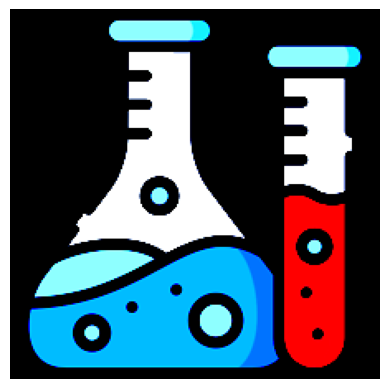

In [43]:
img_path = (
    '/nfs/turbo/coe-chaijy/janeding/regrounding/clip_tl/test_img/flask.png'
)
# gt_label = 'chemistry'
img = Image.open(img_path).convert()  # Ensure it's 3 channels
transforms = get_clip_val_transforms()
img_tensor = transforms(img)
plot_image(img_tensor.detach().cpu(), unstandardise=False)

# Ablation for TC on layers

results = {}
FIX_L = 1
for i in range(FIX_L + 1, 11):
    runner = AblationExperimentRunner(
        model=hookedsaevit,
        transcoders=tc_list,
        img_tensor=img_tensor,
        text_features=text_features,
        labels=final_labels,
        device='cuda',
        activated_layers=[FIX_L, i],
    )
    runner.run_transcoder_baseline(layer_idx=FIX_L, seed=42)
    results[i] = runner.results[f'transcoder_L{FIX_L}_TC{FIX_L}_{i}_seed42'][
        'text_probs'
    ]

results

## Try L1 and 5

In [45]:
runner_L1_5 = AblationExperimentRunner(
    model=hookedsaevit,
    transcoders=tc_list,
    img_tensor=img_tensor,
    text_features=text_features,
    labels=final_labels,
    device='cuda',
    activated_layers=[1, 5],
)
runner_L1_5.run_transcoder_baseline(layer_idx=1, seed=42)
runner_L1_5.results['transcoder_L1_TC1_5_seed42']['text_probs']

Replacing the transcoder layers for L1_5.
--- [Seed 42] Running Transcoder Baseline for L1 ---


{'chemistry': 0.32059502601623535,
 'titration': 0.1483946144580841,
 'experimentation': 0.1313956379890442,
 'science': 0.07199804484844208,
 'science equipment': 0.047188661992549896,
 'technology': 0.0370088592171669,
 'research tools': 0.02706180326640606,
 'graphic': 0.02584078349173069,
 'experiment': 0.023069527000188828,
 'chemical': 0.019389508292078972,
 'test tube': 0.018862372264266014,
 'electrostatics': 0.018215486779808998,
 'solution': 0.017842872068285942,
 'ethicality': 0.007043260149657726,
 'reagent': 0.0059230271726846695,
 'research': 0.004928987938910723,
 'testing': 0.004735670052468777,
 'laboratory bottle': 0.00420342106372118,
 'laboratory': 0.004067030269652605,
 'hardware': 0.003388571087270975}

In [46]:
runner_L1_5.run_ablation_suite(
    layer_idx=1,
    seed=42,
    n_gn_samples=10,
    sigma=2.0,
    batch_mode=True,
    runtime_batch_size=1024,
)

Top activation features number: 2639
--- [Seed 42] Running Zero Ablation for L1 ---
Running zero ablation for chunk 1 of 3...
Zero Ablation Done.
--- [Seed 42] Running Gaussian Noise Ablation for L1 (10 samples) ---
GN Ablation Done.
Running zero ablation for chunk 2 of 3...
Zero Ablation Done.
--- [Seed 42] Running Gaussian Noise Ablation for L1 (10 samples) ---
GN Ablation Done.
Running zero ablation for chunk 3 of 3...
Zero Ablation Done.
--- [Seed 42] Running Gaussian Noise Ablation for L1 (10 samples) ---
GN Ablation Done.
Ablation Suite Done.


In [32]:
runner_L1_5.results.keys()

dict_keys(['transcoder_L1_TC1_5_seed42', 'zero_abl_L1_TC1_5_seed42_each_feature', 'gn_abl_L1_TC1_5_seed42_each_feature'])

In [47]:
# find the top 20 logit difference for 100
# runner.analyze_feature_impact(1, 42, 1, 20)
shallow_logit_diff, shallow_feat_ids = runner_L1_5.analyze_single_concept(
    layer_idx=1,
    seed=42,
    concept_name='science equipment',
    top_k_features=10,
    mode='gn',
)

# ablate the top k features to see if the concept is still there
runner_L1_5.run_ablation_suite(
    layer_idx=1,
    ablation_feature_ids=shallow_feat_ids,
    seed=42,
    n_gn_samples=10,
    sigma=2.0,
    batch_mode=False,
    runtime_batch_size=1024,
)


Base logit for the concept: 20.085433959960938
Top 10 features with largest logit difference for science equipment in gn ablation:
Feature 48184 has the largest logit difference: 2.0168895721435547
Logit for the concept: 18.068544387817383
Feature 44755 has the largest logit difference: 1.532297134399414
Logit for the concept: 18.553136825561523
Feature 13262 has the largest logit difference: 1.130392074584961
Logit for the concept: 18.955041885375977
Feature 5682 has the largest logit difference: 1.043527603149414
Logit for the concept: 19.041906356811523
Feature 29628 has the largest logit difference: 1.023386001586914
Logit for the concept: 19.062047958374023
Feature 33425 has the largest logit difference: 0.9995594024658203
Logit for the concept: 19.085874557495117
Feature 13989 has the largest logit difference: 0.9304656982421875
Logit for the concept: 19.15496826171875
Feature 48397 has the largest logit difference: 0.9158267974853516
Logit for the concept: 19.169607162475586
Fea

In [34]:
runner_L1_5.results.keys()

dict_keys(['transcoder_L1_TC1_5_seed42', 'zero_abl_L1_TC1_5_seed42_each_feature', 'gn_abl_L1_TC1_5_seed42_each_feature', 'zero_abl_L1_TC1_5_seed42_all_features', 'gn_abl_L1_TC1_5_seed42_all_features'])

In [64]:
runner_L1_5.agg_gn_results('gn_abl_L1_TC1_5_seed42_all_features')

({'graphic': 0.2705092430114746,
  'technology': 0.08460656553506851,
  'experimentation': 0.07529199123382568,
  'misappropriation': 0.0370749831199646,
  'uptempo': 0.028375782072544098,
  'inconstantly': 0.02692423202097416,
  'sailed': 0.02678210288286209,
  'funk': 0.02480977401137352,
  'disorganize': 0.023675141856074333,
  'solution': 0.023593997582793236,
  'electrostatics': 0.019907059147953987,
  'ethicality': 0.01783432997763157,
  'determinable': 0.01318801287561655,
  'regenerate': 0.012460512109100819,
  'candidness': 0.012133711948990822,
  'secret': 0.011565906926989555,
  'hardware': 0.011233455501496792,
  'antisocial': 0.011219858191907406,
  'world': 0.010434068739414215,
  'funneled': 0.010227318853139877},
 tensor([17.1520,  7.9416, 11.0976, 12.8049, 15.4398, 10.7742, 16.1657, 16.0722,
         18.3749, 10.9389, 14.4008, 11.5758, 15.3599, 13.8779, 13.6183, 10.8560,
         16.5774, 14.6575, 12.6678, 14.1437, 17.0960, 12.9325, 12.5892, 18.3280,
         10.4524, 

In [66]:
# find the chemistry concept on layer 5
runner_L1_5.run_ablation_suite(
    layer_idx=5,
    seed=42,
    n_gn_samples=10,
    sigma=2.0,
    batch_mode=True,
    runtime_batch_size=1024,
)

deep_logit_diff, deep_feat_ids = runner_L1_5.analyze_single_concept(
    layer_idx=5,
    seed=42,
    concept_name='chemistry',
    top_k_features=10,
    mode='gn',
)

Top activation features number: 2409
--- [Seed 42] Running Zero Ablation for L5 ---
Running zero ablation for chunk 1 of 3...
Zero Ablation Done.
--- [Seed 42] Running Gaussian Noise Ablation for L5 (10 samples) ---
GN Ablation Done.
Running zero ablation for chunk 2 of 3...
Zero Ablation Done.
--- [Seed 42] Running Gaussian Noise Ablation for L5 (10 samples) ---
GN Ablation Done.
Running zero ablation for chunk 3 of 3...
Zero Ablation Done.
--- [Seed 42] Running Gaussian Noise Ablation for L5 (10 samples) ---
GN Ablation Done.
Ablation Suite Done.
Base logit for the concept: 22.0014591217041
Top 10 features with largest logit difference for chemistry in gn ablation:
Feature 19105 has the largest logit difference: 0.243988037109375
Logit for the concept: 21.757471084594727
Feature 7581 has the largest logit difference: 0.171875
Logit for the concept: 21.8295841217041
Feature 606 has the largest logit difference: 0.16771888732910156
Logit for the concept: 21.833740234375
Feature 39754 h

In [69]:
# ablate the top k features to see if the concept is still there
runner_L1_5.run_ablation_suite(
    layer_idx=5,
    ablation_feature_ids=deep_feat_ids,
    seed=42,
    n_gn_samples=10,
    sigma=2.0,
    batch_mode=False,
)


Top activation features number: 2409
--- [Seed 42] Running Zero Ablation for L5 ---
--- [Seed 42] Running Zero Ablation for L5 ---
Zero Ablation Done.
--- [Seed 42] Running Gaussian Noise Ablation for L5 (10 samples) ---
GN Ablation Done.
Ablation Suite Done.


In [71]:
runner_L1_5.agg_gn_results('gn_abl_L5_TC1_5_seed42_all_features')

({'chemistry': 0.2532220184803009,
  'experimentation': 0.20039917528629303,
  'titration': 0.0791768729686737,
  'science': 0.07186168432235718,
  'technology': 0.0633515790104866,
  'graphic': 0.04899157956242561,
  'science equipment': 0.04598945751786232,
  'electrostatics': 0.025219760835170746,
  'experiment': 0.023979321122169495,
  'research tools': 0.02183775044977665,
  'solution': 0.02153300680220127,
  'chemical': 0.017357058823108673,
  'test tube': 0.011825112625956535,
  'ethicality': 0.008844159543514252,
  'testing': 0.005384991876780987,
  'hardware': 0.00511134834960103,
  'reagent': 0.004384201020002365,
  'acid': 0.0042983125895261765,
  'research': 0.004141317214816809,
  'uptempo': 0.0036199218593537807},
 tensor([12.7087,  4.7725, 18.2655, 12.0577, 13.8909, 16.9477, 12.5032, 18.9725,
         16.2016, 13.2847, 13.3014, 15.1545, 17.4789, 15.6734, 11.2597, 11.0368,
         14.5132, 13.7428, 12.5279, 12.4446, 17.2535,  8.0529, 11.2422, 14.5855,
         15.9467, 1

In [72]:
# ablate the shallow layer feature and see the change of the act of deep layer
runner_L1_5.monitor_abl_activations(
    1,
    5,
    42,
    10,
    batch_mode=False,
    runtime_batch_size=1024,
    ablation_feature_ids=shallow_feat_ids,
    monitor_feature_ids=deep_feat_ids,
)

--- [Seed 42] Running Zero Ablation for L1 ---
--- [Seed 42] Running Zero Ablation for L1 ---
Zero Ablation Done.
--- [Seed 42] Running Gaussian Noise Ablation for L1 (10 samples) ---
GN Ablation Done.
Ablation Suite Done.
--- [Seed 42] Analyzing the changes in the mnt features' activations ---
--- [Seed 42] Analyzing the changes in the abl features' activations ---
Analysis Done.


In [73]:
runner_L1_5.results.keys()

dict_keys(['transcoder_L1_TC1_5_seed42', 'zero_abl_L1_TC1_5_seed42_each_feature', 'gn_abl_L1_TC1_5_seed42_each_feature', 'zero_abl_L1_TC1_5_seed42_all_features', 'gn_abl_L1_TC1_5_seed42_all_features', 'transcoder_L5_TC1_5_seed42', 'zero_abl_L5_TC1_5_seed42_each_feature', 'gn_abl_L5_TC1_5_seed42_each_feature', 'zero_abl_L5_TC1_5_seed42_all_features', 'gn_abl_L5_TC1_5_seed42_all_features', 'transcoder_L1_5_TC1_5_seed42', 'mnt_L5_abl1zero_abl_L1_TC1_5_seed42_each_feature', 'mnt_L5_abl1gn_abl_L1_TC1_5_seed42_each_feature', 'analysis_mnt_mnt_L5_abl1TC1_5_seed42', 'analysis_abl_mnt_L5_abl1TC1_5_seed42', 'mnt_L5_abl1zero_abl_L1_TC1_5_seed42_all_features', 'mnt_L5_abl1gn_abl_L1_TC1_5_seed42_all_features'])

In [ ]:
from pprint import pprint

mnt_res = runner_L1_5.results['analysis_mnt_mnt_L5_abl1TC1_5_seed42']
for abl_fid, data in mnt_res.items():
    print(f'Abl Feature ID: {abl_fid}')
    print('*' * 10, 'zero abl summary:', '*' * 10)
    pprint(data['zero_fea_summary'])
    print('*' * 10, 'gn abl summary:', '*' * 10)
    pprint(data['gn_fea_summary'])

Abl Feature ID: 48184
********** zero abl summary: **********
{'all_features': {'ablated_mean_activation': 0.25020647048950195,
                  'baseline_mean_activation': 0.27006593346595764,
                  'direction': 'down',
                  'relative_act': 0.07353560626506805},
 'mnt_features': {'ablated_mean_activation': 14.250128746032715,
                  'baseline_mean_activation': 18.985088348388672,
                  'direction': 'down',
                  'relative_act': 0.24940413236618042},
 'other_features': {'ablated_mean_activation': 0.2473575919866562,
                    'baseline_mean_activation': 0.2662575840950012,
                    'direction': 'down',
                    'relative_act': 0.07098386436700821},
 'per_mnt_feature': {606: {'ablated_sum_activation': 16.361976623535156,
                           'baseline_sum_activation': 24.78717613220215,
                           'direction': 'down',
                           'relative_act': 0.33990154681

In [ ]:
from pprint import pprint

mnt_res = runner_L1_5.results['analysis_abl_mnt_L5_abl1TC1_5_seed42']
for abl_fid, data in mnt_res.items():
    print(f'Abl Feature ID: {abl_fid}')
    print('*' * 10, 'zero abl summary:', '*' * 10)
    pprint(data['zero_fea_summary'])
    print('*' * 10, 'gn abl summary:', '*' * 10)
    pprint(data['gn_fea_summary'])

Abl Feature ID: 48184
********** zero abl summary: **********
{'all_features': {'ablated_mean_activation': 0.0987367033958435,
                  'baseline_mean_activation': 0.10148727893829346,
                  'direction': 'down',
                  'relative_act': 0.02710266411304474},
 'mnt_features': {'ablated_mean_activation': 35.84602737426758,
                  'baseline_mean_activation': 49.36568069458008,
                  'direction': 'down',
                  'relative_act': 0.2738674581050873},
 'other_features': {'ablated_mean_activation': 0.09146242588758469,
                    'baseline_mean_activation': 0.09146242588758469,
                    'direction': 'same',
                    'relative_act': 0.0},
 'per_mnt_feature': {1645: {'ablated_sum_activation': 105.15196990966797,
                            'baseline_sum_activation': 105.15196990966797,
                            'direction': 'same',
                            'relative_act': 0.0},
                    

In [ ]:
runner_L1_5.results['zero_abl_L5_TC1_5_seed42_all_features']['all'][
    'text_probs'
]

{'chemistry': 0.32059502601623535,
 'titration': 0.1483946144580841,
 'experimentation': 0.1313956379890442,
 'science': 0.07199804484844208,
 'science equipment': 0.047188661992549896,
 'technology': 0.0370088592171669,
 'research tools': 0.02706180326640606,
 'graphic': 0.02584078349173069,
 'experiment': 0.023069527000188828,
 'chemical': 0.019389508292078972,
 'test tube': 0.018862372264266014,
 'electrostatics': 0.018215486779808998,
 'solution': 0.017842872068285942,
 'ethicality': 0.007043260149657726,
 'reagent': 0.0059230271726846695,
 'research': 0.004928987938910723,
 'testing': 0.004735670052468777,
 'laboratory bottle': 0.00420342106372118,
 'laboratory': 0.004067030269652605,
 'hardware': 0.003388571087270975}

In [ ]:
tc_list[0].cfg

VisionModelSAERunnerConfig(model_class_name='HookedViT', model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K', vit_model_cfg=None, model_path=None, hook_point_layer=0, layer_subtype='ln2.hook_normalized', hook_point_head_index=None, context_size=50, use_cached_activations=False, use_patches_only=False, cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/open-clip:laion_CLIP-ViT-B-32-DataComp.XL-s13B-b90K/blocks.9.ln2.hook_normalized', image_size=224, architecture='standard', b_dec_init_method='geometric_median', expansion_factor=64, from_pretrained_path=None, is_transcoder=True, transcoder_with_skip_connection=True, out_hook_point_layer=0, layer_out_subtype='hook_mlp_out', d_out=768, _device='cuda', seed=42, _dtype='float32', d_in=768, activation_fn_str='topk', activation_fn_kwargs={'k': 768}, cls_token_only=False, max_grad_norm=1.0, initialization_method='independent', normalize_activations='layer_norm', n_batches_in_buffer=20, sto

In [ ]:
# keep the target features
total_fea_num = tc_list[0].cfg.d_sae
abl_features = runner_L1_5.get_inverse_ids(shallow_feat_ids, total_fea_num)

runner_L1_5.run_ablation_suite(
    layer_idx=1,
    seed=42,
    n_gn_samples=10,
    sigma=2.0,
    batch_mode=False,
    runtime_batch_size=1024,
    ablation_feature_ids=abl_features,
    output_prefix='keep_shallow_feat_',
)

Top activation features number: 2639
--- [Seed 42] Running Zero Ablation for L1 ---
--- [Seed 42] Running Zero Ablation for L1 ---
Zero Ablation Done.
--- [Seed 42] Running Gaussian Noise Ablation for L1 (10 samples) ---


GN Ablation Done.
Ablation Suite Done.


In [ ]:
runner_L1_5.results.keys()

dict_keys(['transcoder_L1_TC1_5_seed42', 'zero_abl_L1_TC1_5_seed42_each_feature', 'gn_abl_L1_TC1_5_seed42_each_feature', 'zero_abl_L1_TC1_5_seed42_all_features', 'gn_abl_L1_TC1_5_seed42_all_features', 'transcoder_L5_TC1_5_seed42', 'zero_abl_L5_TC1_5_seed42_each_feature', 'gn_abl_L5_TC1_5_seed42_each_feature', 'zero_abl_L5_TC1_5_seed42_all_features', 'gn_abl_L5_TC1_5_seed42_all_features', 'transcoder_L1_5_TC1_5_seed42', 'mnt_L5_abl1zero_abl_L1_TC1_5_seed42_each_feature', 'mnt_L5_abl1gn_abl_L1_TC1_5_seed42_each_feature', 'analysis_mnt_L5_abl1TC1_5_seed42', 'keep_shallow_featzero_abl_L1_TC1_5_seed42_all_features', 'keep_shallow_featgn_abl_L1_TC1_5_seed42_all_features', 'keep_shallow_feat_zero_abl_L1_TC1_5_seed42_all_features', 'keep_shallow_feat_gn_abl_L1_TC1_5_seed42_all_features'])

In [ ]:
runner_L1_5.results['keep_shallow_feat_gn_abl_L1_TC1_5_seed42_all_features'][0][
    'all'
]

{'text_probs': {'equivalence': 0.1483469307422638,
  'experimentation': 0.057922326028347015,
  'graphic': 0.049537450075149536,
  'solution': 0.043882980942726135,
  'determinable': 0.04143582284450531,
  'placidness': 0.037868548184633255,
  'candidness': 0.026098575443029404,
  'misappropriation': 0.02566319890320301,
  'immorality': 0.024013027548789978,
  'technology': 0.02248765528202057,
  'trustless': 0.022339098155498505,
  'funk': 0.02200547605752945,
  'ethicality': 0.020759832113981247,
  'corrupt': 0.020609714090824127,
  'inconstantly': 0.01954696886241436,
  'sailed': 0.019056761637330055,
  'edged': 0.018303651362657547,
  'premonition': 0.01821352355182171,
  'secret': 0.016934601590037346,
  'electrostatics': 0.01629837229847908},
 'logits': tensor([15.6273, 11.5802, 15.2983, 11.1219, 13.4184, 14.4869,  8.6593, 15.2854,
         14.2036, 12.9189, 11.7604, 16.1493, 13.4427, 12.9502, 11.7207, 11.4611,
         14.4375,  8.7298, 13.9266, 11.5794, 12.1916, 16.5841, 12.329

# Old

In [ ]:
# find the top 20 logit difference for 100
runner.analyze_feature_impact(0, 42, 1, 20)
top_k_logit_diff, top_k_feat_ids = runner.analyze_single_concept(
    layer_idx=0,
    seed=42,
    concept_name='laboratory bottle',
    top_k_features=20,
    mode='zero',
)

# ablate the top k features to see if the concept is still there
runner.run_ablation_suite(
    layer_idx=0,
    ablation_feature_ids=top_k_feat_ids,
    seed=42,
    n_gn_samples=10,
    sigma=2.0,
    batch_mode=False,
)
runner.results['zero_ablation_L0_seed42_all_features']['all']['text_probs']

Top 1 features with highest impact:
Feature 25737 has the largest change in text probabilities: 10.588614463806152
Top 20 negative words: {'lapboard': '-1.2820', 'provided': '-1.1584', 'experimentation': '-1.1334', 'cultivatable': '-1.0853', 'associational': '-1.0709', 'graphic': '-1.0633', 'moneyman': '-1.0406', 'regenerate': '-1.0327', 'hockey stick': '-0.9887', 'potbelly': '-0.9720', 'inclusiveness': '-0.9701', 'twit': '-0.9613', 'thyself': '-0.9431', 'damnably': '-0.9401', 'reconnaissance': '-0.9367', 'illuminate': '-0.9363', 'emptiness': '-0.9330', 'relapse': '-0.9258', 'concert': '-0.9236', 'Swiss chard': '-0.9146'}
Top 20 positive words: {'guesthouse': '0.4554', 'flask': '-0.0542', 'science equipment': '-0.1873', 'graduated tube': '-0.2040', 'mixture': '-0.2081', 'hippopotamus': '-0.2142', 'apparatus': '-0.2153', 'chemistry': '-0.2169', 'beaker': '-0.2212', 'test tube': '-0.2224', 'titration': '-0.2291', 'glassware': '-0.2424', 'drum kit': '-0.2587', 'trachea': '-0.2633', 'long 

{'chemistry': 0.22205208241939545,
 'research tools': 0.21729044616222382,
 'science': 0.10595043003559113,
 'science equipment': 0.08035141229629517,
 'reaction': 0.039525289088487625,
 'chemical': 0.03738505020737648,
 'ethicality': 0.03645625337958336,
 'reagent': 0.03261404111981392,
 'titration': 0.02472684159874916,
 'experimentation': 0.017969492822885513,
 'test tube': 0.017690295353531837,
 'research': 0.013601364567875862,
 'distillation': 0.012843393720686436,
 'laboratory bottle': 0.012749548070132732,
 'experiment': 0.012206331826746464,
 'flask': 0.010572710074484348,
 'laboratory': 0.007793701719492674,
 'equivalence': 0.007493027951568365,
 'graphic': 0.007045052479952574,
 'solution': 0.006237167399376631}

In [ ]:
runner.results.keys()

dict_keys(['original_clip_seed42', 'transcoder_L1_TC1_7_seed42', 'zero_abl_L1_TC1_7_seed42_each_feature', 'gn_abl_L1_TC1_7_seed42_each_feature'])

In [ ]:
top_k_logit_diff, top_k_feat_ids = runner.analyze_single_concept(
    layer_idx=0,
    seed=42,
    concept_name='flask',
    top_k_features=1,
    mode='gn',
)

Base logit for the concept: 12.93919849395752
Top 1 features with largest logit difference for flask in gn ablation:
Feature 39603 has the largest logit difference: 0.3448143005371094
Logit for the concept: 12.59438419342041


In [ ]:
# ablate the top k features to see if the concept is still there
runner.run_ablation_suite(
    layer_idx=0,
    ablation_feature_ids=top_k_feat_ids,
    seed=42,
    n_gn_samples=10,
    sigma=2.0,
    batch_mode=False,
)

Replacing the transcoder layers for L0_9.
--- [Seed 42] Running Transcoder Baseline for L0 ---
Activations captured.
--- [Seed 42] Running Zero Ablation for L0 ---
--- [Seed 42] Running Zero Ablation for L0 ---
Zero Ablation Done.
--- [Seed 42] Running Gaussian Noise Ablation for L0 (10 samples) ---
GN Ablation Done.
Ablation Suite Done.


In [ ]:
runner.results['gn_abl_L0_TC0_9_seed42_all_features'][0]['all']

{'text_probs': {'funneled': 0.11743934452533722,
  'knelt': 0.10808387398719788,
  'flask': 0.09735256433486938,
  'depersonalization': 0.05512203648686409,
  'which': 0.040526580065488815,
  'provided': 0.03952052816748619,
  'graphic': 0.037601038813591,
  'cosigner': 0.03650515526533127,
  'handsomely': 0.03599335625767708,
  'thyself': 0.03437698632478714,
  'engagingness': 0.028975004330277443,
  'biologist': 0.025070779025554657,
  'hockey stick': 0.020171310752630234,
  'isle': 0.0177654717117548,
  'proficiently': 0.017592959105968475,
  'discovery': 0.014204802922904491,
  'commercial': 0.013600829057395458,
  'holler': 0.01256959605962038,
  'deflower': 0.012242713011801243,
  'sample': 0.012179316952824593},
 'logits': tensor([ 8.2810, -3.3493,  1.4283, 10.0345,  9.8625,  6.3111,  4.5546,  5.0874,
         11.3745,  9.6252,  3.8613,  8.9264,  5.3220,  5.3424,  3.3106,  7.7716,
          3.8867,  7.0685,  6.3925,  6.3779,  4.4353,  5.1685, -0.9130,  7.1718,
         10.9988, 

In [ ]:
runner.results['transcoder_L0_seed42']

{'text_probs': {'chemistry': 0.19754554331302643,
  'laboratory bottle': 0.11423620581626892,
  'reagent': 0.11333337426185608,
  'chemical': 0.1004834845662117,
  'science': 0.08708768337965012,
  'research tools': 0.0841355100274086,
  'reaction': 0.03261430934071541,
  'liquid': 0.028813498094677925,
  'titration': 0.027000539004802704,
  'test tube': 0.025303339585661888,
  'experiment': 0.025279028341174126,
  'solvent': 0.023206986486911774,
  'science equipment': 0.021823661401867867,
  'experimentation': 0.01626974157989025,
  'research': 0.01358125638216734,
  'solution': 0.01234480645507574,
  'flask': 0.010753047652542591,
  'ethicality': 0.009960091672837734,
  'beaker': 0.007937333546578884,
  'vial': 0.005947170313447714},
 'logits': tensor([15.8622, 16.0926, 17.0741, 19.1550, 14.5661, 21.7385, 14.0408, 15.9768,
         17.7439, 22.8405, 15.5526, 15.5778, 17.3461, 14.6775,  9.9504, 15.2838,
         19.6227, 17.4092, 23.2812, 14.7258, 19.0720, 16.1108, 13.6402, 18.2747,


In [ ]:
# find if 'chemistry' is in the value of the keys
# zero noise
for i in range(len(runner.results['zero_ablation_L0_seed42_all_features'])):
    for key, value in runner.results[
        'zero_ablation_L0_seed42_all_features'
    ].items():
        if 'test tube' not in value['text_probs']:
            print(value)
        break

In [ ]:
# gaussian noise
no_target_found = 0
for i in range(len(runner.results['gn_ablation_L0_seed42_all_features'])):
    for key, value in runner.results['gn_ablation_L0_seed42_all_features'][
        i
    ].items():
        if 'test tube' not in value['text_probs']:
            print(value)
            no_target_found += 1
print(no_target_found)


{'text_probs': {'uptempo': 0.24299997091293335, 'chemistry': 0.07799568772315979, 'experimentation': 0.06506412476301193, 'research tools': 0.05123889446258545, 'equivalence': 0.04986099898815155, 'experiment': 0.0488385334610939, 'chemical': 0.048580531030893326, 'reagent': 0.03278970345854759, 'science': 0.02553742378950119, 'reaction': 0.024055713787674904, 'ethicality': 0.020280370488762856, 'graphic': 0.018735643476247787, 'laboratory bottle': 0.016565052792429924, 'handbrake': 0.013377712108194828, 'candidness': 0.013151132501661777, 'solvent': 0.01241375133395195, 'depersonalization': 0.011682567186653614, 'solution': 0.010908620432019234, 'acid': 0.010446690022945404, 'science equipment': 0.00900715496391058}, 'logits': tensor([14.9806, 17.8880, 17.5399, 19.9343, 16.8668, 18.6753, 13.7478, 16.4352,
        17.3844, 22.0673, 14.9331, 16.2992, 18.6636, 14.7711,  9.8930, 14.3346,
        18.7606, 17.1138, 21.7804, 17.6872, 18.4524, 15.3411, 16.3602, 17.6951,
        14.5467,  9.57

In [ ]:
# 2 layers transcoders replacement
transcoder_l1 = tc_list[1]
transcoder_l7 = tc_list[7]

runner_2_layers = AblationExperimentRunner(
    model=hookedsaevit,
    transcoders=[transcoder_l1, transcoder_l7],
    img_tensor=img_tensor,
    text_features=text_features,
    labels=final_labels,
    device='cuda',
)